In [19]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
from sklearn import preprocessing
from sklearn import cluster
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 250

sys.path.append('../')
import read_player_stats
import training_data

In [20]:
#change position and adjust parameters for sheet here
position = 'wr'

#parameters for positions
pages = {'qb': [0,1], 'rb': [0,1,2,3], 'wr': [0,1,2,3], 'te': [0,1]}
starters = {'qb': 12, 'rb': 30, 'wr': 42, 'te': 12}
n_clusters = {'qb': 3, 'rb': 3, 'wr': 4, 'te': 3}

#read in data and make training samples
total_df = training_data.make_total_data(seasons=range(2004,2015), pages=pages[position], pos=position)
train_df = training_data.make_training_df(total_df, seasons=range(2004,2014), ppg=True)

In [21]:
#model
model = training_data.train_player_model(train_df)
#data for 2015 projections
most_rec = training_data.data_for_projection(total_df, season=2015)

proj = training_data.ff_projection(most_rec, model)
baseline = proj.loc[starters[position], '2015 Projection']

In [22]:
#calculate values relative to last likely starter
base_sub = proj['2015 Projection'] - baseline
proj['Value Above Baseline'] = base_sub
proj.head()

,Name,2015 Projection,Value Above Baseline
1,AntonioBrown,19.570178,10.394666
2,DemaryiusThomas,18.163368,8.987856
3,DezBryant,17.307398,8.131886
4,JordyNelson,17.071224,7.895712
5,AlshonJeffery,15.762167,6.586655


Group 0
mean: 13.2573033708
std: 4.4813860794
Group 1
mean: 4.25740740741
std: 3.96902832833
Group 2
mean: 7.78120104439
std: 4.38849214531
Group 3
mean: 9.0
std: 6.1717996655


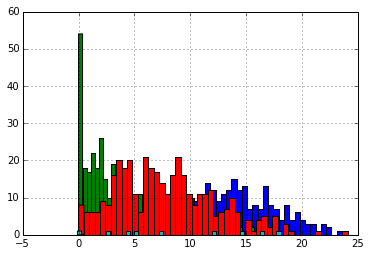

In [23]:
#clusters
clust, model = training_data.cluster_players(train_df, n_clusters=n_clusters[position])

In [24]:
#Get groups for
X_pred = np.array(most_rec.drop(['Name', '2015 Projection'], axis=1))
X_pred = preprocessing.scale(X_pred)
y_pred = model.predict(X_pred)

In [25]:
most_rec['Group'] = y_pred

In [26]:
summary_table = pd.merge(proj, most_rec[['Name', 'Group']], on='Name', how='inner')

In [27]:
summary_table

,Name,2015 Projection,Value Above Baseline,Group
0,AntonioBrown,19.570178,10.394666,0
1,DemaryiusThomas,18.163368,8.987856,0
2,DezBryant,17.307398,8.131886,0
3,JordyNelson,17.071224,7.895712,0
4,AlshonJeffery,15.762167,6.586655,0
5,RandallCobb,15.729187,6.553675,0
6,JulioJones,15.438448,6.262936,0
7,EmmanuelSanders,15.199328,6.023816,0
8,CalvinJohnson,14.987153,5.811641,0
9,AJGreen,14.445573,5.270061,0
